# Lab 5: Clustering
Let $C_i: i=1,...,k$ be $k$ classes and $P(x|C_i)$ be the probability density function of a data point $x$ given the class $C_i$. Let $P(C_i)$ be the probability of the class $C_i$. The marginal density is

$$P(x) = \sum_i P(X|C_i)P(C_i)$$

In the supervised cases, where the $k$ classes are given, the density function and the probability of the class $C_i$ can be estimated from the training set. 

This chapter focuses on the unsupervised learning problem where the labels are not given and we will discuss two algorithms - k-means clustering and Expectation-Maximization algorithm


## k-means clustering
Given k, the k-means algorithm includes two major steps. In step 1, given k means $\{m_i\}$, a data point $x$ is assigned to class $i$ if 

$$||x-m_i|| = min_j||x-m_j||$$

In step 2, given the assignments we update the k means $\{m_i\}$ by the average of the assigned data points for class $C_i$. We iteratively update the assignments and k means until they converge. 

The k-means algorithm highly depend on the initial $m_i$. To overcome this problem we may

1. take random numbers as the initial $m_i$
2. calculate the overall mean and small random vectors may be added to the overall mean to get the k initial $m_i$
3. calculate the PCA and devide its range into k equal intervals partitioning the data into k groups

### K-means algorithm for clustering points

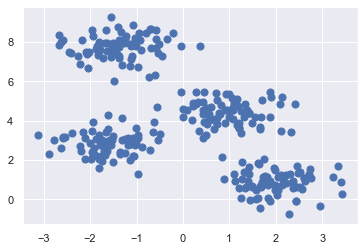

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

By eye, it is relatively easy to pick out the four clusters. The k-means algorithm does this automatically, and in Scikit-Learn uses the typical estimator API:

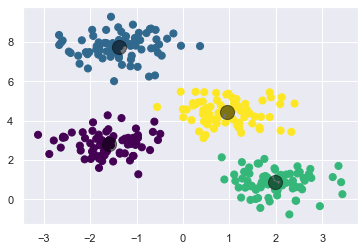

In [2]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

### k-means on digits

#### load data

In [3]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

#### perform kmeans clustering

In [4]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

#### visualizing result

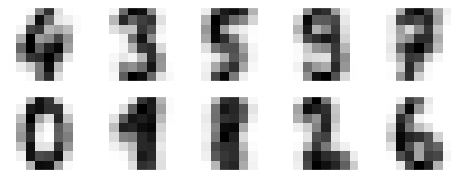

In [5]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

We see that even without the labels, KMeans is able to find clusters whose centers are recognizable digits, with perhaps the exception of 1 and 8.

In [6]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

In [7]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7935447968836951

Let's check the confusion matrix

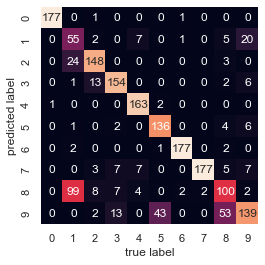

In [8]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

## Expectation-Maximization algorithm
Given the density function $P(x|C_i)$ and the class probability $P(C_i)$, the loglikelihood is given by

$$\sum_tlog\big{\{}\sum_{i=1}^kP(x^t|C_i)P(C_i)\big{\}}$$

It is difficult to find the maximum likelihood estimate of the k classes. We use the expectation-maximization algorithm to find the MLE in which the latent variable is an indicator variable of the assignments of a data point. 

Thus, in the expectation step, the expectation of the latent variable is the posterior probability $P(C_i|x)$.

In the maximization step, the model parameters for class $C_i$ are estimated using ML and the probablity $P(C_i)$ of class $i$ is estimated by the proportion of data points in the class $C_i$. 

## GMM for clustering

[[0.026 0.002 0.972 0.   ]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    0.    1.   ]
 [0.001 0.    0.999 0.   ]]


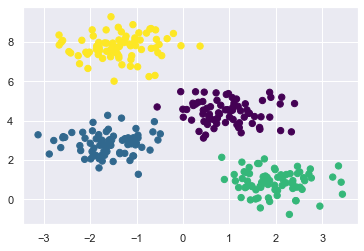

In [9]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

probs = gmm.predict_proba(X)
print(probs[:5].round(3))

Plot points, making the size of each point proportional to the certainty of its prediction

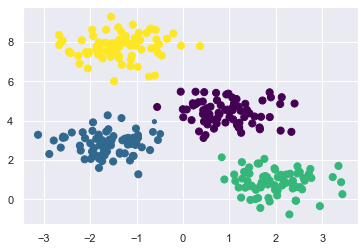

In [10]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

## Mixture of Latent Variable Models
We look for latent variables that generate the data in the clusters, i.e.,

$$P(X^t|C_i) = Normal(m_i, V_iV_i^T+\Psi_i)$$

where $V_i$ and $\Psi_i$ are factor loadings and specific variances of cluster $C_i$. This can be extended to mixture models to find mixtures of factor analyzers. The EM algorithm can be updated accordingly to find $V$ and $\Psi$.

## Supervised learning after clustering
Clustering like the dimensionality reduction methods can be used for data exploration or to understand the structure of data by grouping instances based on their similarities.

If such groups are found we can choose the group mean as the representative prototype of instances in the group or possible range. This allows a simpler description of the data. 

In the case of classification, when each class is a mixture model composed of a number of components, the whole density is a miture of mixtures. Learning parameters of components is done separately for each class.

## Hierarchical clustering
The aim is to find groups such that observations in a group are more similar to each other than obervations in different groups. Similarity is measured by a distance function.

An agglomerative clustering algorithm starts with N groups each containing one training observation, merging similar groups to form larger groups until there is a single group

A divisive clustering algorithm starts with a single group and divide large groups into smaller groups until each group contains a single observation.

### Clustering digits

#### load data

In [11]:
# Authors: Gael Varoquaux
# License: BSD 3 clause (C) INRIA 2014

print(__doc__)
from time import time

import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt

from sklearn import manifold, datasets

X, y = datasets.load_digits(return_X_y=True)
n_samples, n_features = X.shape

np.random.seed(0)

def nudge_images(X, y):
    # Having a larger dataset shows more clearly the behavior of the
    # methods, but we multiply the size of the dataset only by 2, as the
    # cost of the hierarchical clustering methods are strongly
    # super-linear in n_samples
    shift = lambda x: ndimage.shift(x.reshape((8, 8)),
                                  .3 * np.random.normal(size=2),
                                  mode='constant',
                                  ).ravel()
    X = np.concatenate([X, np.apply_along_axis(shift, 1, X)])
    Y = np.concatenate([y, y], axis=0)
    return X, Y


X, y = nudge_images(X, y)

Automatically created module for IPython interactive environment


#### Visualizing clusters

(3594, 64)


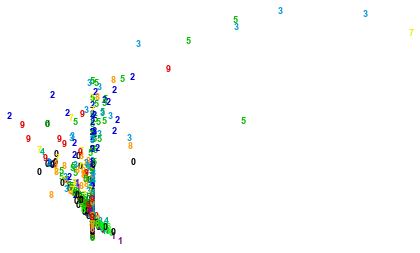

In [12]:
def plot_clustering(X_red, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(6, 4))
    for i in range(X_red.shape[0]):
        plt.text(X_red[i, 0], X_red[i, 1], str(y[i]),
                 color=plt.cm.nipy_spectral(labels[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

print(X.shape)
plot_clustering(X, y)

#### Computing embedding

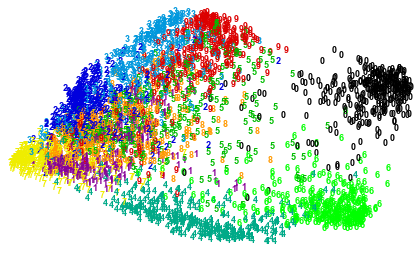

In [13]:
#----------------------------------------------------------------------
# 2D embedding of the digits dataset
print("")
X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X)
plot_clustering(X_red, y)

#### Hierarchical clustering

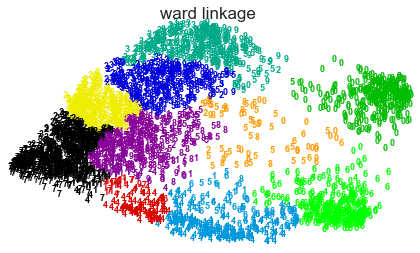

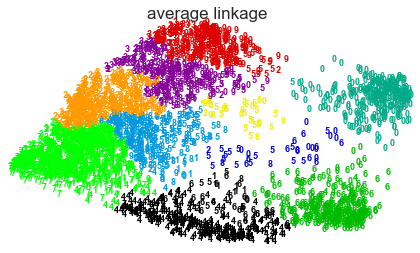

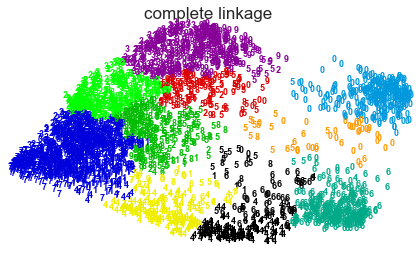

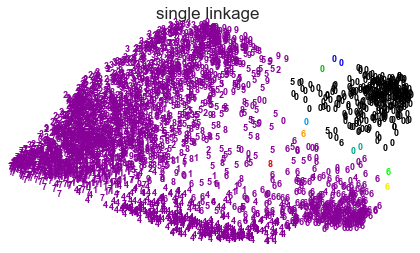

In [14]:
from sklearn.cluster import AgglomerativeClustering

for linkage in ('ward', 'average', 'complete', 'single'):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=10)
    #t0 = time()
    clustering.fit(X_red)
    #print("%s :\t%.2fs" % (linkage, time() - t0))
    plot_clustering(X_red, clustering.labels_, "%s linkage" % linkage)

## Choosing k the number of clusters
In some applications, k is defined by the application
Plotting the data in two dimensions using PCA may be used in uncovering the number of clusters
Setting a maximum allowed distance may help to find k
We can plot the reconstruction error or loglikelihood as a function of k and look for the elbow (cross validation)

### Silhouette analysis
Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

In this example the silhouette analysis is used to choose an optimal value for n_clusters. The silhouette plot shows that the n_clusters value of 3, 5 and 6 are a bad pick for the given data due to the presence of clusters with below average silhouette scores and also due to wide fluctuations in the size of the silhouette plots. Silhouette analysis is more ambivalent in deciding between 2 and 4.

Also from the thickness of the silhouette plot the cluster size can be visualized. The silhouette plot for cluster 0 when n_clusters is equal to 2, is bigger in size owing to the grouping of the 3 sub clusters into one big cluster. However when the n_clusters is equal to 4, all the plots are more or less of similar thickness and hence are of similar sizes as can be also verified from the labelled scatter plot on the right.

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.7049787496083261


For n_clusters = 3 The average silhouette_score is : 0.5882004012129721
For n_clusters = 4 The average silhouette_score is : 0.6505186632729437


For n_clusters = 5 The average silhouette_score is : 0.56376469026194


For n_clusters = 6 The average silhouette_score is : 0.4504666294372765


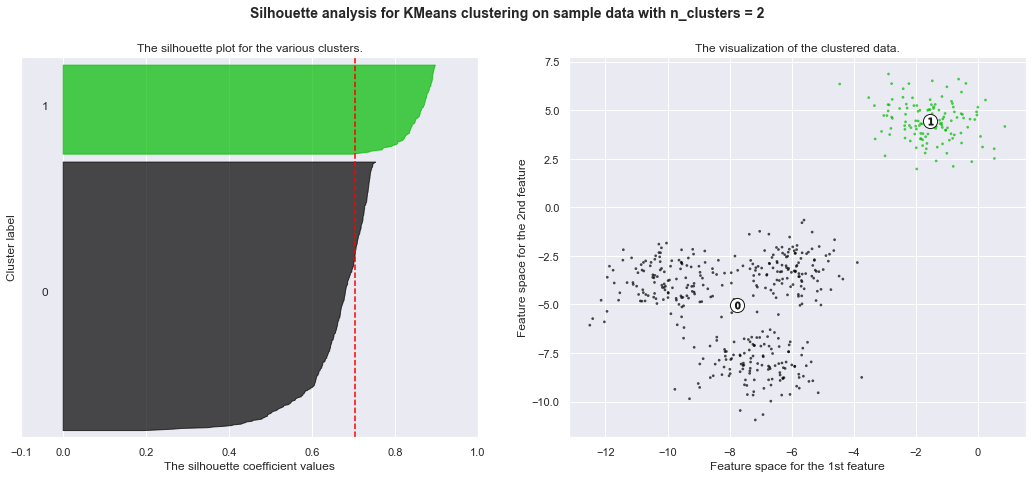

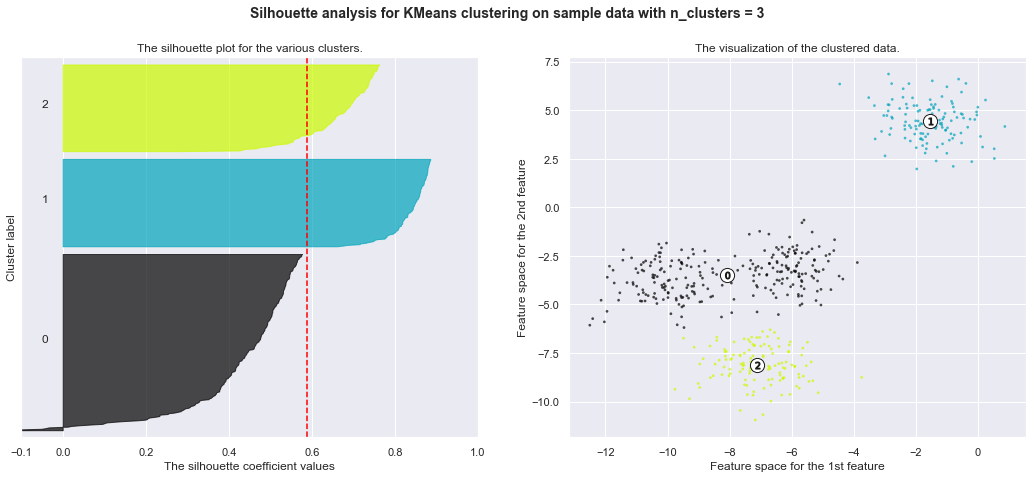

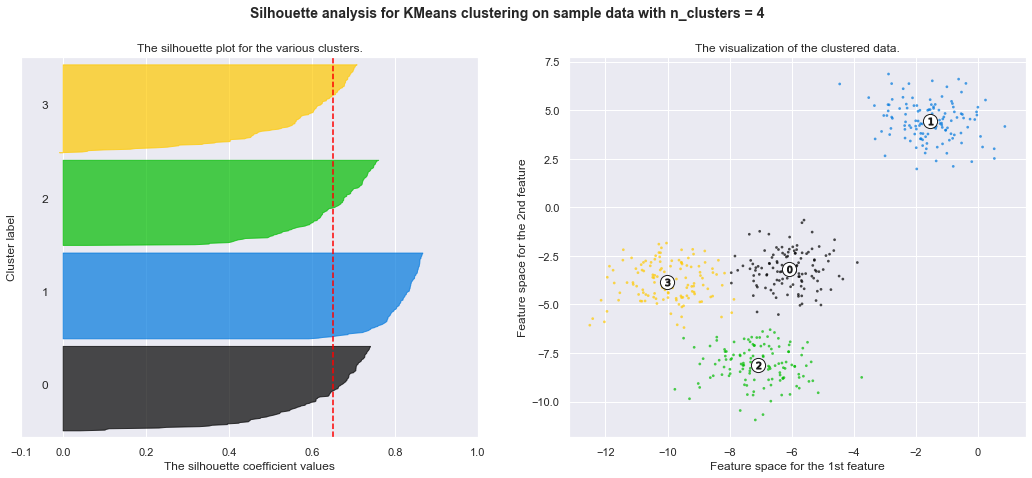

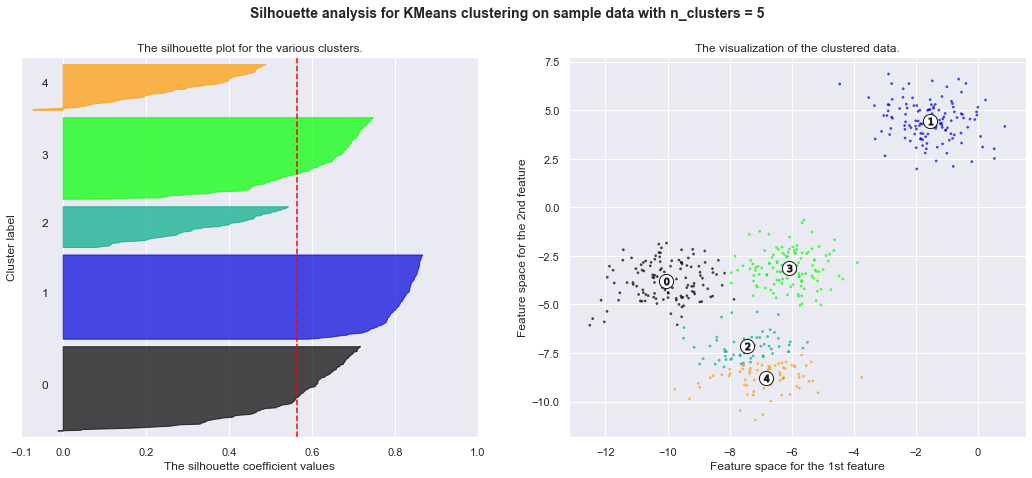

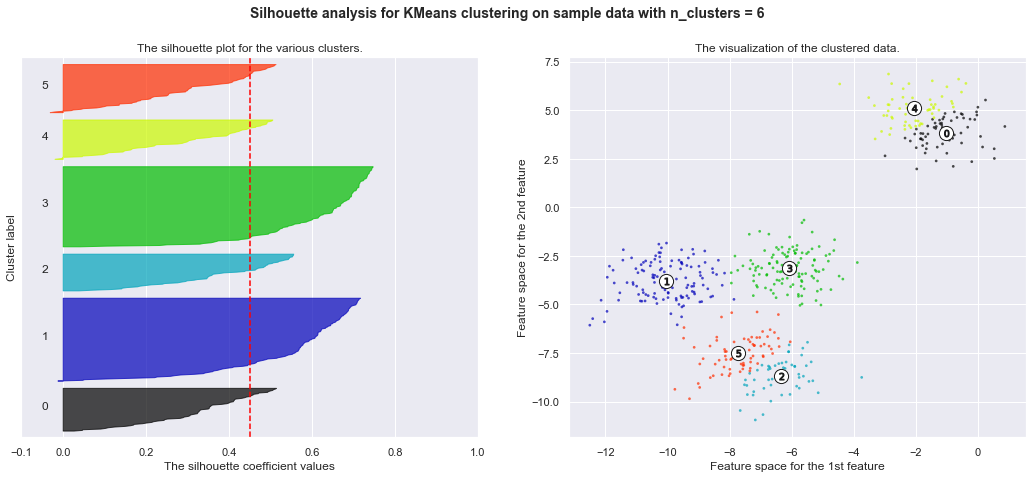

In [15]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()